In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pretty_midi --quiet

In [3]:
!pip install mir_eval --quiet

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import PIL
import PIL.Image as Image
from IPython import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import os
import pretty_midi
import mir_eval.display
import librosa.display

from scipy import sparse
from scipy.sparse import csr_matrix

### EDA

In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/'
labels = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

In [6]:
def process_midi_directory(directory):
    pr_list = []
    labels = []
    composers = os.listdir(directory)  # Assuming subdirectories are named after composers
    for composer in composers:
        composer_dir = os.path.join(directory, composer)
        if os.path.isdir(composer_dir):
            for filename in os.listdir(composer_dir):
                if filename.endswith('.mid') or filename.endswith('.midi'):
                    midi_path = os.path.join(composer_dir, filename)
                    midi_data = None
                    try:
                        midi_data = pretty_midi.PrettyMIDI(midi_path)
                        #piano_roll = midi_data.get_piano_roll(fs=100)
                        #piano_roll_sparse = csr_matrix(piano_roll)
                    except:
                        print(midi_path)
                        continue
                    # transpose and scale
                    #pr_list.append(piano_roll.T / 127.0)
                    pr_list.append(midi_data)
                    labels.append(composer)
    return pr_list, labels

songs, labels = process_midi_directory(data_dir)

/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/Mozart/K281 Piano Sonata n03 3mov.mid


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


/content/drive/MyDrive/Colab Notebooks/AAI-511/Final_Project/dataset/Beethoven/Anhang 14-3.mid


In [7]:
composers = os.listdir(data_dir)
print(composers)

['Mozart', 'Chopin', 'Bach', 'Beethoven']


### Visualizations

<ipython-input-8-d90b55345213>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll[start_pitch:end_pitch],


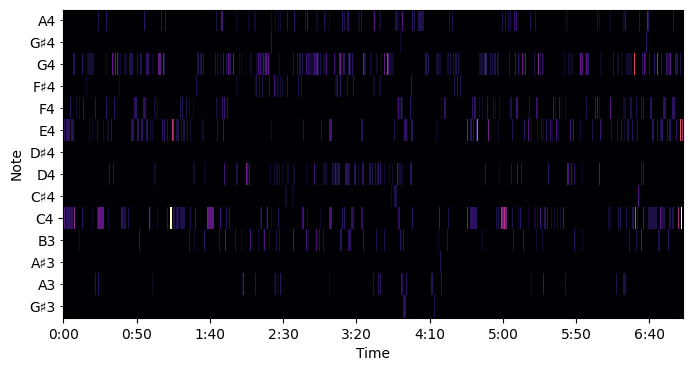

In [8]:
def plot_piano_roll(piano_roll, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(piano_roll[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

example = songs[0].get_piano_roll(fs=100)
plt.figure(figsize=(8, 4))
plot_piano_roll(example, 56, 70)

### Preprocessing
Piano roll format takes a lot of memory. We will create a custom data pipeline that converts the pretty midi object to piano roll, pad and scale it at training time.

In [ ]:
# Get max length for padding.

max_time_steps = max(songs.get_piano_roll(fs=100).shape[1] for songs in songs)
max_notes = max(songs.get_piano_roll(fs=100).shape[0] for songs in songs)

In [ ]:
print(max_time_steps)
print(max_notes)

The max_time steps is way too large. We need to compromise and truncate the input so we can get a model that can reasonably run.

In [9]:
# Pipeline functions

def get_piano_roll(midi):
    return midi.get_piano_roll(fs=100)

def preprocess_piano_roll(piano_roll, max_time_steps, max_notes):
    padded_roll = np.zeros((max_notes, max_time_steps))
    num_notes = min(piano_roll.shape[0], max_notes)
    num_time_steps = min(piano_roll.shape[1], max_time_steps)
    padded_roll[:num_notes, :num_time_steps] = piano_roll[:num_notes, :num_time_steps]
    scaled_roll = padded_roll.T / 127.0
    return scaled_roll

In [10]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y = lb.fit_transform(labels)

In [14]:
print(len(songs))

1529


In [26]:
X = []

for song in songs:
    piano_roll = song.get_piano_roll(fs=100)
    preprocessed_roll = preprocess_piano_roll(piano_roll, 1000, 128)
    X.append(preprocessed_roll)

X = np.array(X)

In [27]:
# Train test val split 70:15:15
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

### CNN model

In [30]:
# Define the model
CNNmodel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01),
                           input_shape=(1000, 128, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
CNNmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

CNNmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 998, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 499, 63, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 497, 61, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 248, 30, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 476160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      30,474,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,493,380 (116.32 MB)

 Trainable params: 30,493,380 (116.32 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = CNNmodel.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.5485 - loss: 1.5864 - val_accuracy: 0.5721 - val_loss: 1.3310
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7003 - loss: 1.0801 - val_accuracy: 0.6812 - val_loss: 1.0525
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7920 - loss: 0.7384 - val_accuracy: 0.6507 - val_loss: 1.0748
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8631 - loss: 0.5452 - val_accuracy: 0.7074 - val_loss: 1.0231
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9432 - loss: 0.3512 - val_accuracy: 0.7031 - val_loss: 1.2674
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9613 - loss: 0.2683 - val_accuracy: 0.6987 - val_loss: 1.3056
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9679 - loss: 0.2583 - val_accuracy: 0.6288 - val_loss: 1.3989
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9667 - loss: 0.2426 - val_accuracy: 0.6681 -

Text(0.5, 0, 'epoch')

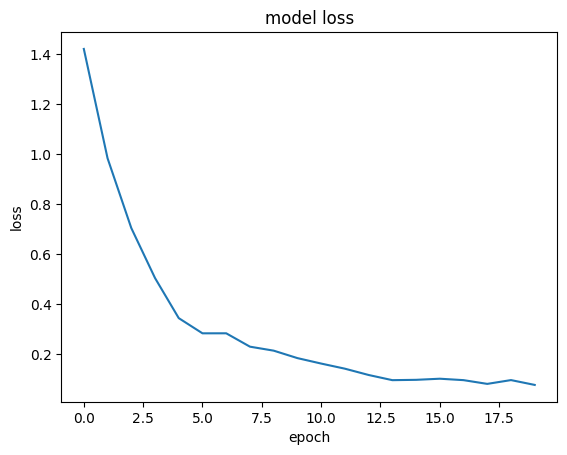

In [32]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [33]:
predictions = CNNmodel.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
test_loss, test_accuracy = CNNmodel.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6492 - loss: 1.8291
Test accuracy: 0.656521737575531


References: <br>
https://github.com/craffel/pretty-midi/blob/main/Tutorial.ipynb